In [1]:
# Import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from xgboost import XGBRegressor

In [2]:
#import csv file
df = pd.read_csv("BTC.csv")
df=df.reset_index()['Price']
df

0        8245.7
1        8245.1
2        8529.0
3        8403.3
4        8006.0
         ...   
1822    26920.0
1823    27183.9
1824    27035.3
1825    27403.1
1826    26828.0
Name: Price, Length: 1827, dtype: float64

In [3]:
# Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df).reshape(-1,1))

In [4]:
# Spliting train test
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
#  Define Random Forest Model
model = XGBRegressor(n_estimators=100)
model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [8]:
# Predict test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

In [9]:
# Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred.reshape(-1,1))
y_pred_val=scaler.inverse_transform(y_pred_val.reshape(-1,1))

In [10]:
# Respliting train test
train_size1 = int(0.6 * len(df))
test_size1 = int(0.3 * len(df))
train_data1 = df[:train_size1]
test_data1 = df[train_size1:train_size1+test_size1]
val_data1 = df[train_size1+test_size1:]

# Repredictions on the testing set
x_test1 = np.array(test_data1.index).reshape(-1, 1)
y_test1 = np.array(test_data1)

# Repredictions on the validate set
x_val1 = np.array(val_data1.index).reshape(-1, 1)
y_val1 = np.array(val_data1)

In [11]:
# Calculate evalution
#RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val1)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test1)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAPE
valid_mape = np.mean(np.abs((y_val1 - y_pred_val) / y_val1)) * 100
test_mape = np.mean(np.abs((y_test1 - y_pred) / y_test1)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

#MAE
valid_mae = np.mean(np.abs(y_pred_val - y_val1))
test_mae = np.mean(np.abs(y_pred - y_test1))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 18556.793230317293
Testing RMSE: 16995.690868344205
Validation MAPE: 86.77474010373044
Testing MAPE: 52.83160116044186
Validation MAE: 17932.519053628548
Testing MAE: 13845.50273314391


In [12]:
# Predict next 30days
pred_next = np.array([])

y_val_to_next=scaler.fit_transform(np.array(y_val1[-time_step:].reshape(1,-1).reshape(1,time_step)).reshape(-1,1))

for i in range(30):
    print(y_val_to_next)
    y_pred_next = model.predict(y_val_to_next.reshape(1,-1))
    y_val_to_next = np.append(y_val_to_next,y_pred_next[0])[1:]
    pred_next = np.append(pred_next,y_pred_next[0])

next30days_predict_inverse = pd.DataFrame(scaler.inverse_transform(pred_next.reshape(-1,1)))

[[0.27219411]
 [0.15857229]
 [0.14330445]
 [0.16509626]
 [0.15801974]
 [0.15664321]
 [0.19792939]
 [0.40435061]
 [0.32793385]
 [0.42815875]
 [0.4337715 ]
 [0.40192714]
 [0.45394443]
 [0.41625468]
 [0.39065317]
 [0.36638942]
 [0.2941895 ]
 [0.29172725]
 [0.32978538]
 [0.32352314]
 [0.28827624]
 [0.33787976]
 [0.320741  ]
 [0.21304213]
 [0.21233448]
 [0.2202059 ]
 [0.21843192]
 [0.19786153]
 [0.1506524 ]
 [0.01988212]
 [0.        ]
 [0.03012854]
 [0.17818298]
 [0.3836542 ]
 [0.44039241]
 [0.39996898]
 [0.46990054]
 [0.70136102]
 [0.65509219]
 [0.75631555]
 [0.73322476]
 [0.77137013]
 [0.6887493 ]
 [0.79043797]
 [0.7081855 ]
 [0.70948448]
 [0.75775025]
 [0.67596309]
 [0.68879777]
 [0.79428643]
 [0.76317881]
 [0.80623897]
 [0.80453285]
 [0.77954206]
 [0.74113496]
 [0.77625584]
 [0.77713798]
 [0.76387677]
 [0.75163342]
 [0.75461913]
 [0.79197929]
 [0.91939549]
 [0.97451482]
 [0.94318424]
 [0.99175052]
 [1.        ]
 [0.9832393 ]
 [0.98427655]
 [0.89941643]
 [0.99124644]
 [0.83919812]
 [0.78

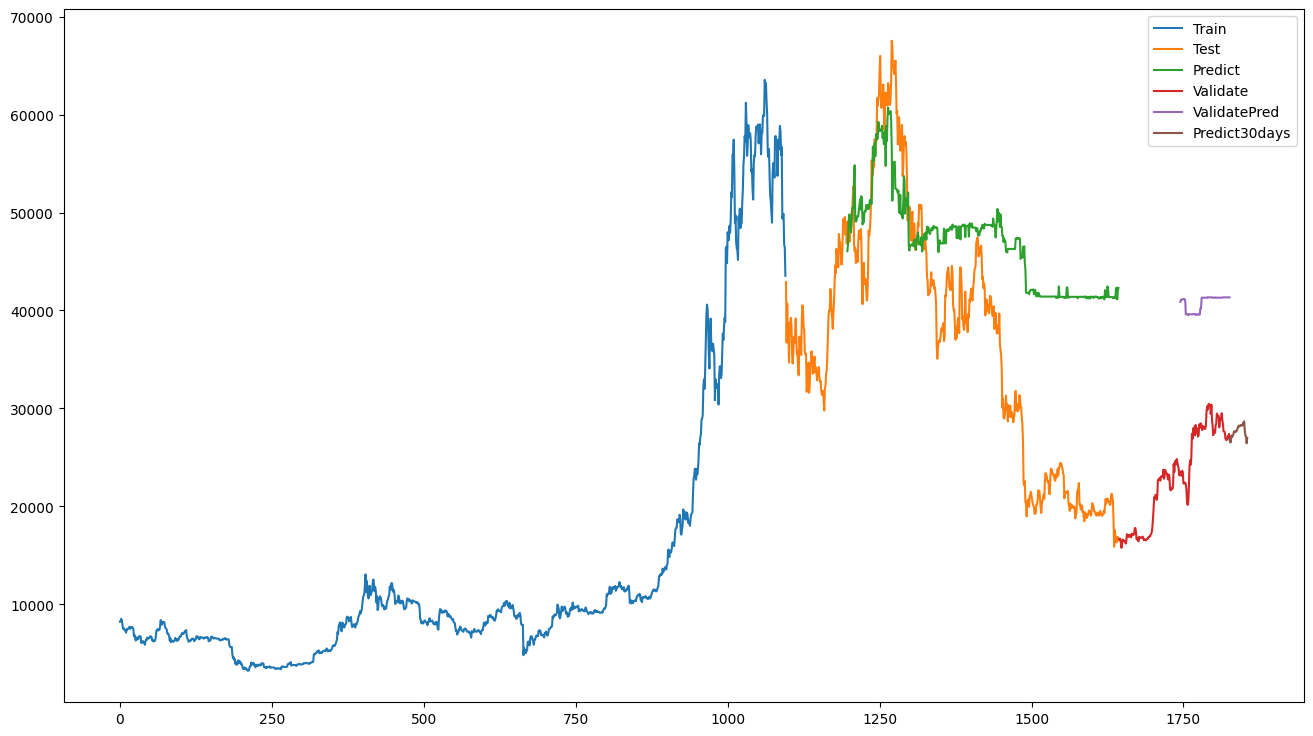

In [13]:
# Visualize
plt.figure(figsize =(16, 9))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index,train_data1)
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,test_data1)
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,val_data1)
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,next30days_predict_inverse)
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()